# Sensor Fusion

In this notebook you'll implement sensor functionality to refine the distribution. You'll use ground truth sensor measurements $z_t$ (k-element vector) to compute the probability the vehicle is at/near a state $x_t$:

$p(x_t | z_t)$

Once you have these probabilities or weights, they can be used generate new (refined) samples from the current distribution.

Lectures: 
1. https://youtu.be/Qwzd-9SmSxc
2. https://youtu.be/5MPNYyKvHbc
3. https://youtu.be/K2bd8zcoicU


In [5]:
%matplotlib inline

import numpy as np
import numpy.linalg as LA
import matplotlib.pyplot as plt
import scipy.stats as stats
from bresenham import bresenham
from utils import create_grid, inbounds

In [15]:
plt.rcParams['figure.figsize'] = 12, 12

Load map.

In [4]:
data = np.loadtxt('colliders.csv', delimiter=',', dtype='Float64', skiprows=2)
grid, _, _ = create_grid(data)
print(type(grid)) 

<class 'numpy.ndarray'>


Implementation of Lidar sensor - `LidarSensor`, and sensor related functions. Look for the `TODOs`!

In [11]:
class LidarSensor:
    def __init__(self, max_range):
        self._max_range = max_range
        
    @property
    def max_range(self):
        return self._max_range
    
    def _random_measure(self):
        return np.random.randint(0, self._max_range+1)
    
    def _failure_measure(self):
        return self._max_range
    
    def _hit_measure(self, expected_dist):
        return np.random.normal(expected_dist)
    
    def measure(self, expected_dist):
        p = np.random.rand()
        if p <= 0.95:
            return self._hit_measure(expected_dist)
        elif p <= 0.98:
            return self._random_measure()
        return self._failure_measure()
    
    def lookup_prob(self, expected_dist, measured_dist):
        norm_prob = 0.95 * stats.norm.pdf(measured_dist, loc=expected_dist)
        random_prob = 0.03 * (1 / self._max_range)
        failure_prob = 0
        if measured_dist == self._max_range:
            failure_prob = 0.02
        return norm_prob + random_prob + failure_prob
    
def sense(grid, sensor, ground_truth_state, rays):
    """Generate a number of sensor measurements, `rays` from the ground truth
    state `ground_truth_state`.
    """
    measured_distances = []
    dists = shoot_rays(grid, sensor, ground_truth_state, k=rays)
    for d in dists:
        measured_distances.append(sensor.measure(d))
    return measured_distances

def sensor_fusion(grid_map, sensor, samples, measured_distances):
    """Given sampled states, `samples` and ground truth sensor
    distance measurements, `measured_distances` return the new mean
    state and standard deviation estimates.
    """
    weights = []
    for s in samples:
        weight = importance(grid_map, sensor, s, measured_distances)
        weights.append(weight)
        
    # normalize weights
    weights = np.array(weights)
    weights /= np.sum(weights)
        
    return np.array(weights)

def shoot_rays(grid_map, sensor, state, k):
    """
    Shoot `k` number of rays the given state, `state`.
    The rays will be evenly spaced.
    """
    x, y, theta = state
    expected_distances = []
    for i, bearing in enumerate(range(k)):
        bearing = bearing * (360 / k)
        angle = (theta + np.radians(bearing)) % (2 * np.pi)
        expected_dist, _ = get_distance(grid_map, sensor, x, y, angle)
        expected_distances.append(expected_dist)
    return expected_distances

def importance(grid_map, sensor, state, measured_distances):
    """Returns the "importance" of the sampled `state` based
    on a comparison between the `measured_distances` and the
    distances measured from the sampled state.
    """
    expected_distances = shoot_rays(grid_map, sensor, state, k=len(measured_distances))
    weight = 1
    
    # TODO: calculate the importance weight given expected and measured distances
    # the weight value should be in the range [0, 1]
    for (ed, md) in zip(expected_distances, measured_distances):
        weight *= sensor.lookup_prob(ed, md)
        
    return weight


def get_distance(grid_map, sensor, x, y, angle):
    """Uses bresenham to find the distance to the nearest
    obstacle on the map from an observation at x, y pointed
    in a certain angle. If no obstacle is hit the max sensor range
    is returned.
    
    Return the distance `dist` and location of the obstacle hit `loc`.
    
    If the ray leads out of bounds returns the maximum sensor distance and
    x, y location at that distance.
    """
    # TODO: complete implementation
        
    x2 = x + sensor.max_range * np.cos(angle)
    y2 = y + sensor.max_range * np.sin(angle)
    
    cells = bresenham(int(x), int(y), int(x2), int(y2))    
    
    dist = sensor.max_range
    loc = [x2, y2]
    
    for c in cells:
        if not inbounds(grid_map, c[0], c[1]):
            return dist, loc
        if grid_map[c[1], c[0]] == 1:
            dist = LA.norm(np.array([x, y]) - np.array([c[0], c[1]]))
            loc = [c[0], c[1]]
            break
    return dist, loc

In [10]:
max_sensor_range = 100
sensor = LidarSensor(max_sensor_range)

# ground truth state
# NOTE: shooting a lidar ray from this state should hit an obstacle at location
# [435, 500], distance 70.7106781187

ground_truth_state = [385, 450, np.radians(45)]

dist, loc = get_distance(grid, sensor, ground_truth_state[0], ground_truth_state[1], 
                         ground_truth_state[2])
print(dist, loc)

70.71067811865476 [435, 500]


We'll create a handful of samples to test the weight distribution. Samples most similar to the ground truth state should be assigned the highest weight values.

In [12]:
samples = np.array([
    [400, 440, ground_truth_state[2]],
    [820, 135, ground_truth_state[2]],
    [720, 800, ground_truth_state[2]],
    [160, 800, ground_truth_state[2]],
    [400, 440, -ground_truth_state[2]],
])

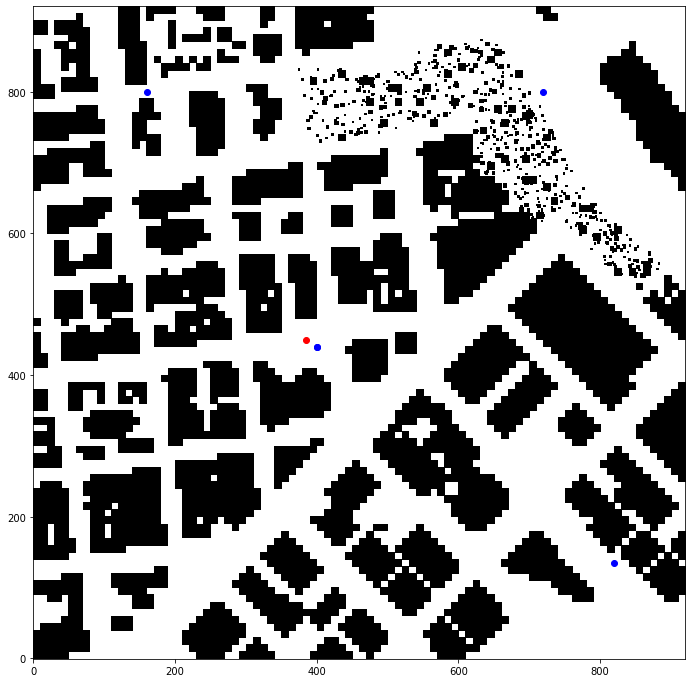

In [16]:
plt.imshow(grid, origin='lower', cmap='Greys')

# ground truth state
plt.plot(ground_truth_state[0], ground_truth_state[1], 'ro')

# sample states
plt.plot(samples[:, 0], samples[:, 1], 'bo')

Next you'll make a number of sensor measurements from the ground truth state and compute weight probabilities. The higher the probabilities, the greater the likelihood the sample is representative of the ground truth.

In [17]:
# TODO: Use `sense` to take sensor measurements from the ground truth state.

# sense(grid, sensor, ground_truth_state, rays):
measured_distances = sense(grid, sensor, ground_truth_state, 16)

#sensor_fusion(grid_map, sensor, samples, measured_distances):
weights = sensor_fusion(grid, sensor, samples, measured_distances)

for (w, s) in zip(weights, samples):
    print('weight value', w, 'state', s)

weight value 0.9999999999036442 state [400.         440.           0.78539816]
weight value 2.2818950385177935e-11 state [8.20000000e+02 1.35000000e+02 7.85398163e-01]
weight value 2.281895134375444e-11 state [7.20000000e+02 8.00000000e+02 7.85398163e-01]
weight value 5.067396153078215e-11 state [1.60000000e+02 8.00000000e+02 7.85398163e-01]
weight value 4.4058007718417226e-14 state [400.         440.          -0.78539816]


The state with the largest weight value by far (> 99%) should be `[ 400., 440., 0.78539816]`.